# Overview of data

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt

with open("corpus-dataset/andalusian_nawba.json", "r") as file:
    data = json.load(file)

results = data.get("results", [])

df_nawba = pd.DataFrame(results)

df_nawba


,id,name,transliterated_name
0,1,الاستهلال,al-istihlāl
1,2,الاصبهان,al-āṣbhān
2,3,الحجاز الكبير,al-ḥjāz al-kabīr
3,4,الحجاز المشرقي,al-ḥjāz al-mashriqī
4,5,الرصد,al-ruṣṣad
5,6,العشاق,al-‘ushshāq
6,7,الماية,al-māīyah
7,8,بدون,bidūn
8,9,بواكر الماية,bawākir al-māīyah
9,10,رصد الذيل,ruṣid al-dhayl


In [9]:
with open("corpus-dataset/andalusian_description.json") as file:
    data = (json.load(file))


section_list = []
mbids = []
for entry in data:
    for section in entry.get('sections', []):
        mbids.append(entry.get('mbid'))
        section_list.append(section)

df_section = pd.DataFrame(section_list)
df_section['track_id'] = mbids

df_section

,start_time,tab,nawba,end_time,form,mizan,track_id
0,00:00:03,"{'id': 16, 'name': 'رمل الماية', 'transliterat...","{'id': 11, 'name': 'رمل الماية', 'transliterat...",00:01:36,"{'id': 17, 'name': 'المشالية', 'transliterated...","{'id': 1, 'name': 'بدون', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
1,00:01:37,"{'id': 16, 'name': 'رمل الماية', 'transliterat...","{'id': 11, 'name': 'رمل الماية', 'transliterat...",00:05:16,"{'id': 26, 'name': 'توشية النوبة', 'transliter...","{'id': 2, 'name': 'بسيط', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
2,00:05:17,"{'id': 16, 'name': 'رمل الماية', 'transliterat...","{'id': 11, 'name': 'رمل الماية', 'transliterat...",00:13:37,"{'id': 21, 'name': 'الموسع', 'transliterated_n...","{'id': 2, 'name': 'بسيط', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
3,00:13:38,"{'id': 16, 'name': 'رمل الماية', 'transliterat...","{'id': 11, 'name': 'رمل الماية', 'transliterat...",00:27:28,"{'id': 18, 'name': 'المهزوز', 'transliterated_...","{'id': 2, 'name': 'بسيط', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
4,00:27:29,"{'id': 16, 'name': 'رمل الماية', 'transliterat...","{'id': 11, 'name': 'رمل الماية', 'transliterat...",00:31:18,"{'id': 1, 'name': 'إنشاد', 'transliterated_nam...","{'id': 2, 'name': 'بسيط', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
...,...,...,...,...,...,...,...
842,00:00:00,"{'id': 1, 'name': 'الاستهلال', 'transliterated...","{'id': 1, 'name': 'الاستهلال', 'transliterated...",00:02:20,"{'id': 17, 'name': 'المشالية', 'transliterated...","{'id': 1, 'name': 'بدون', 'transliterated_name...",023b4a37-1ab4-4593-b03a-850ee0db8350
843,00:02:21,"{'id': 1, 'name': 'الاستهلال', 'transliterated...","{'id': 1, 'name': 'الاستهلال', 'transliterated...",00:05:50,"{'id': 24, 'name': 'توشية الميزان', 'translite...","{'id': 10, 'name': 'قائم ونصف', 'transliterate...",023b4a37-1ab4-4593-b03a-850ee0db8350
844,00:05:50,"{'id': 1, 'name': 'الاستهلال', 'transliterated...","{'id': 1, 'name': 'الاستهلال', 'transliterated...",00:33:26,"{'id': 21, 'name': 'الموسع', 'transliterated_n...","{'id': 10, 'name': 'قائم ونصف', 'transliterate...",023b4a37-1ab4-4593-b03a-850ee0db8350
845,00:33:27,"{'id': 1, 'name': 'الاستهلال', 'transliterated...","{'id': 1, 'name': 'الاستهلال', 'transliterated...",01:29:47,"{'id': 18, 'name': 'المهزوز', 'transliterated_...","{'id': 10, 'name': 'قائم ونصف', 'transliterate...",023b4a37-1ab4-4593-b03a-850ee0db8350


Text(0.5, 0, 'sections')

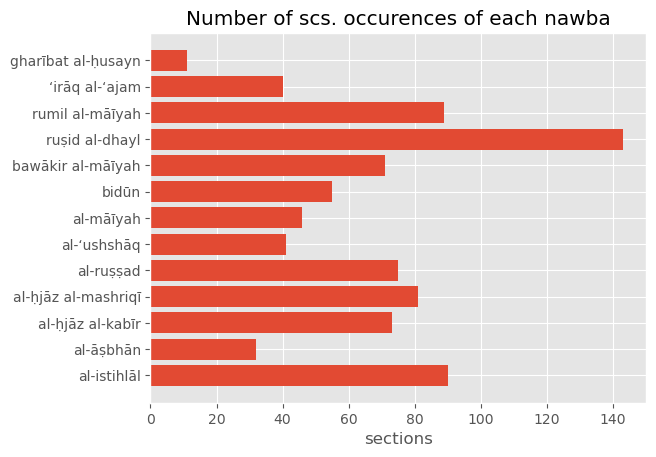

In [4]:

occurences_nawba = []
for name in df_section['nawba'].unique():
    #print(f"{len(df_nawba[df_nawba['transliterated_name'] == name])} = population of {name} in dataset")
    occurences_nawba.append(len(df_section[df_section['nawba'] == name]))

plt.style.use("ggplot")
plt.barh(df_nawba['transliterated_name'].unique(), occurences_nawba)
plt.title("Number of scs. occurences of each nawba")
plt.xlabel("sections")


Text(0.5, 0, 'Minutes')

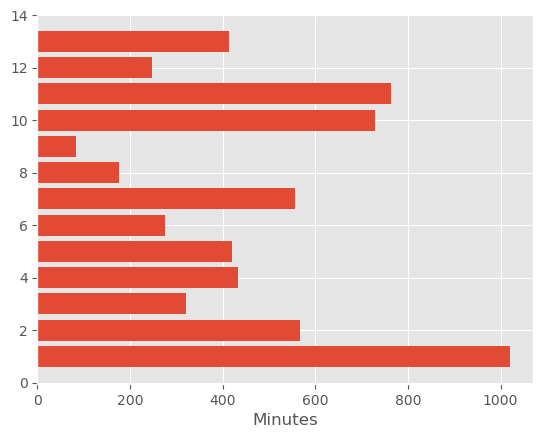

In [5]:


total_time_list = []
df_section["start_time"] = pd.to_datetime(df_section["start_time"], format="%H:%M:%S")
df_section["end_time"] = pd.to_datetime(df_section["end_time"], format="%H:%M:%S")
df_section["duration"] = df_section["end_time"] - df_section["start_time"]
df_section["duration_in_seconds"] = df_section["duration"].dt.total_seconds()

bins_playing_time = []
for name in df_section["nawba"].unique():
    bins_playing_time.append(sum(df_section[df_section["nawba"] == name]["duration_in_seconds"]) // 60)


plt.barh(df_section["nawba"].unique(), bins_playing_time)
plt.xlabel("Minutes")

Text(0.5, 0, 'sections')

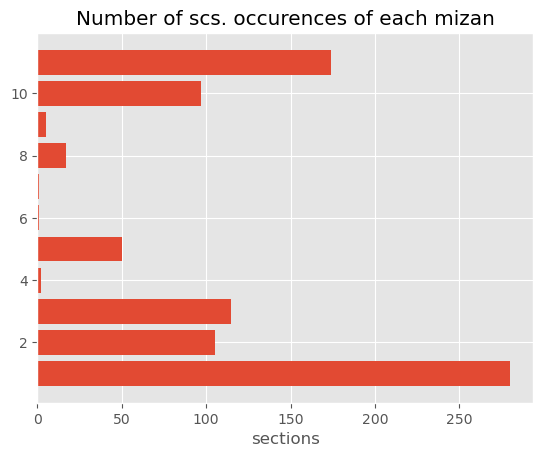

In [6]:
occurences_mizan = []
for name in df_section['mizan'].unique():
    occurences_mizan.append(len(df_section[df_section['mizan'] == name]))

plt.barh(df_section['mizan'].unique(), occurences_mizan)
plt.title("Number of scs. occurences of each mizan")
plt.xlabel("sections")

Text(0.5, 0, 'sections')

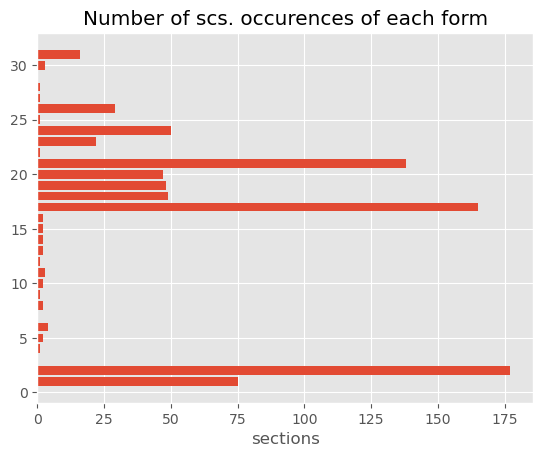

In [ ]:
occurences_form = []
for name in df_section['form'].unique():
    occurences_form.append(len(df_section[df_section['form'] == name]))


plt.barh(df_section['form'].unique(), occurences_form, )
plt.title("Number of scs. occurences of each form")
plt.xlabel("sections")


Text(0.5, 0, 'sections')

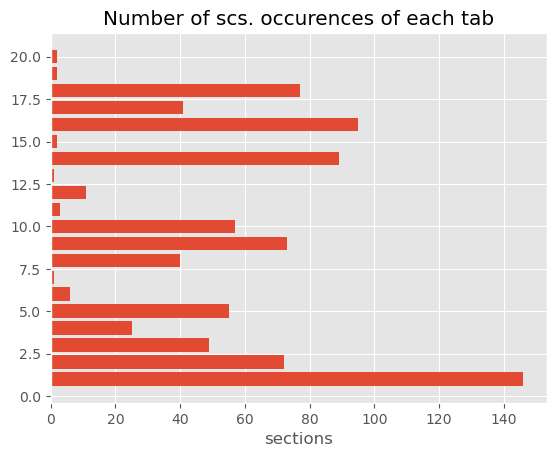

In [8]:
occurences_tab = []
for name in df_section['tab'].unique():
    occurences_tab.append(len(df_section[df_section['tab'] == name]))


plt.barh(df_section['tab'].unique(), occurences_tab, )          
plt.title("Number of scs. occurences of each tab")
plt.xlabel("sections")

In [9]:
pitch_df = pd.read_csv("corpus-dataset/documents/f7c00e6e-7b07-47ba-bfdd-146ddbf9adb5/pitch_filtered.txt", delimiter="\t", names= ["pitch", "time"])
pitch_df

,pitch,time
0,0.000000,0.0
1,0.002902,0.0
2,0.005805,0.0
3,0.008707,0.0
4,0.011610,0.0
...,...,...
862763,2504.164717,0.0
862764,2504.167619,0.0
862765,2504.170522,0.0
862766,2504.173424,0.0


In [ ]:
from utilities.constants import *
with open(DF_PATH + "andalusian_nawba.json", "r") as file:
    data = json.load(file)
pitch_distr = pd.read_json(DF_PATH_TRACKS + "f7c00e6e-7b07-47ba-bfdd-146ddbf9adb5/audioanalysis--pitch_distribution.json")
pitch_distr

,kernel_width,vals,ref_freq,bins
0,7.5,1.137714e-09,NaN,88.961531
1,7.5,3.800098e-08,NaN,89.347764
2,7.5,4.702388e-07,NaN,89.735673
3,7.5,2.206109e-06,NaN,90.125266
4,7.5,4.236742e-06,NaN,90.516551
...,...,...,...,...
550,7.5,3.594318e-07,NaN,963.813176
551,7.5,7.095180e-08,NaN,967.997636
552,7.5,5.544805e-09,NaN,972.200263
553,7.5,1.625306e-10,NaN,976.421135


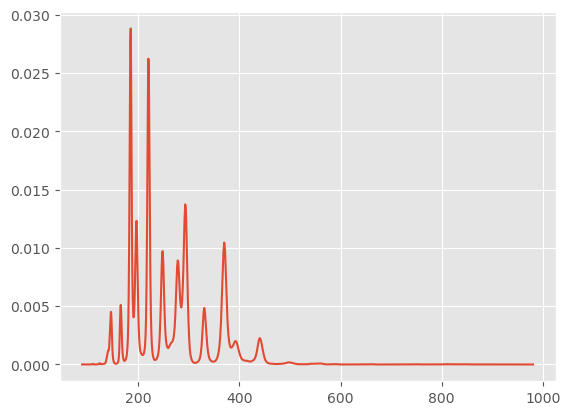

In [11]:
plt.plot(pitch_distr["bins"], pitch_distr["vals"])

In [ ]:
with open(DF_PATH + "andalusian_description.json") as file:
    data = (json.load(file))

section_list = []

for entry in data:
    if entry.get('mbid') == '0386e377-7212-43e5-89b6-7f4c42d0ae74':
        for section in entry.get('sections', []):
            section_list.append(section)

df_section = pd.DataFrame(section_list)
columns_totranslate = ["tab", "nawba", "mizan", "form"]

for name in columns_totranslate:
    df_section[name] = df_section[name].apply(lambda x: x["id"])

df_section

,start_time,tab,nawba,end_time,form,mizan
0,00:00:00,14,10,00:05:17,28,6
1,00:05:26,12,9,00:07:45,17,1
2,00:07:46,12,9,00:12:30,2,3
3,00:12:30,12,9,00:13:47,24,11
4,00:13:47,12,9,00:23:48,21,11
5,00:23:48,12,9,00:37:17,21,11
6,00:37:18,12,9,00:40:03,23,1
7,00:40:04,12,9,01:01:16,19,11
8,01:01:16,12,9,01:04:10,20,11
9,01:04:11,12,9,01:20:50,2,11


In [ ]:
from utilities.corpus_search import *
print(get_ids_tracks_with_multiple_nawba())

['0386e377-7212-43e5-89b6-7f4c42d0ae74']
